# Problem: Forecasting Stock Prices using Machine Learning Algorithms

## Method: LSTM
## Data: Stock market prices from Investing.com
## Libraries:
- argparse
- pandas
- numpy
- scipy
- tensorflow
- matplotlib
- scikit-learn (sklearn)
- statsmodels
- seaborn

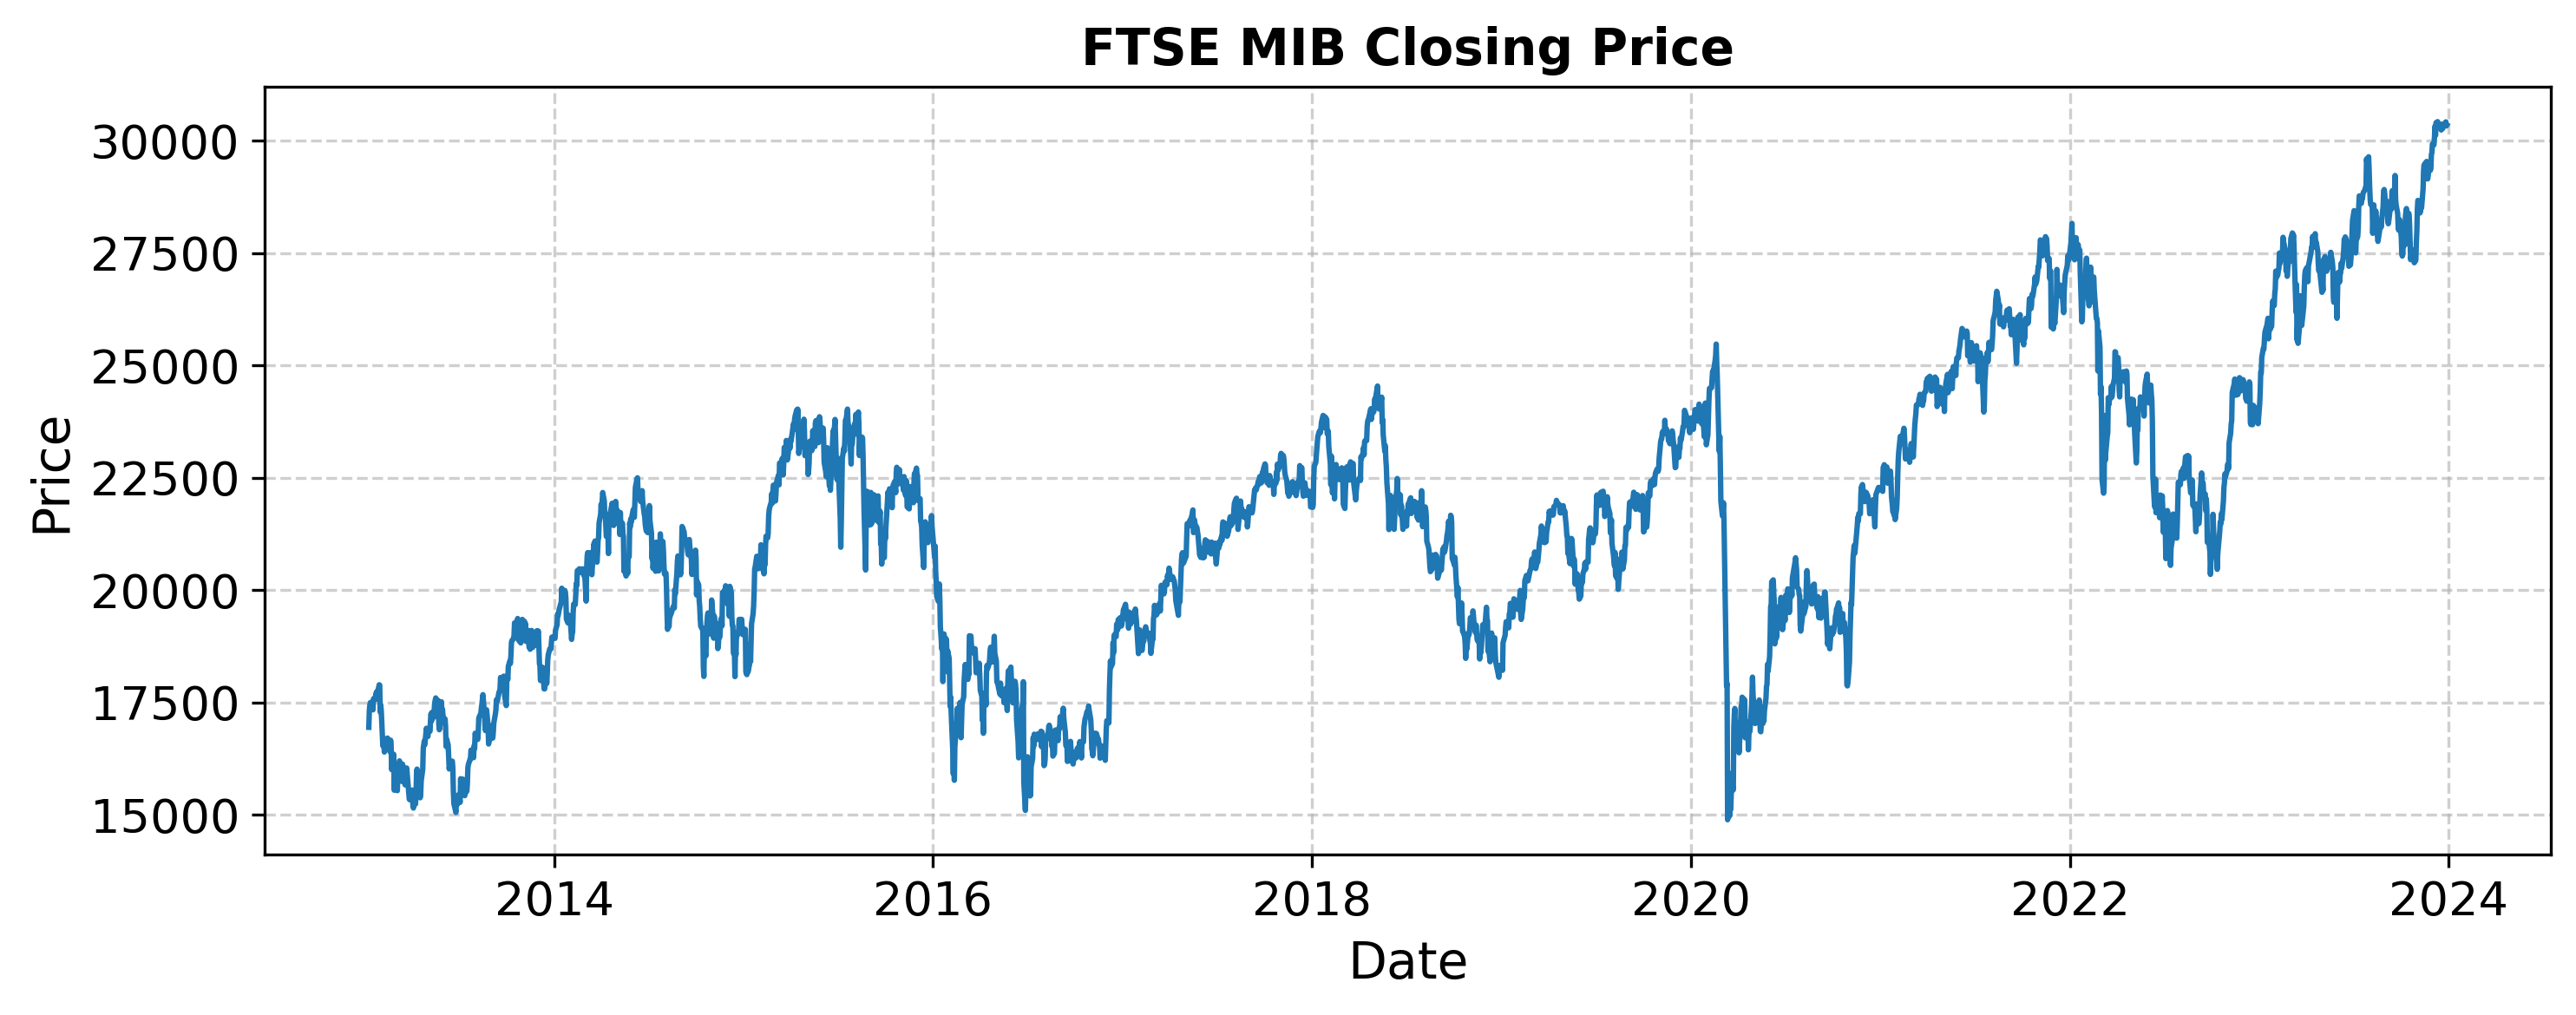

Data leakage check: scalers fitted only on training data
Lookahead bias check passed


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Rolling validation RMSEs: ['511.72', '341.85', '583.21']



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test RMSE: 388.34
Test MAE: 295.94
Test MAPE: 1.17%
Test R^2: 0.9766
Residual Ljung-Box p-value (lag 10): 0.0000
t-test p-value: 0.0000
Residual Mean: 70.6398
Residual Ljung-Box p-value (lag 10): 0.0000


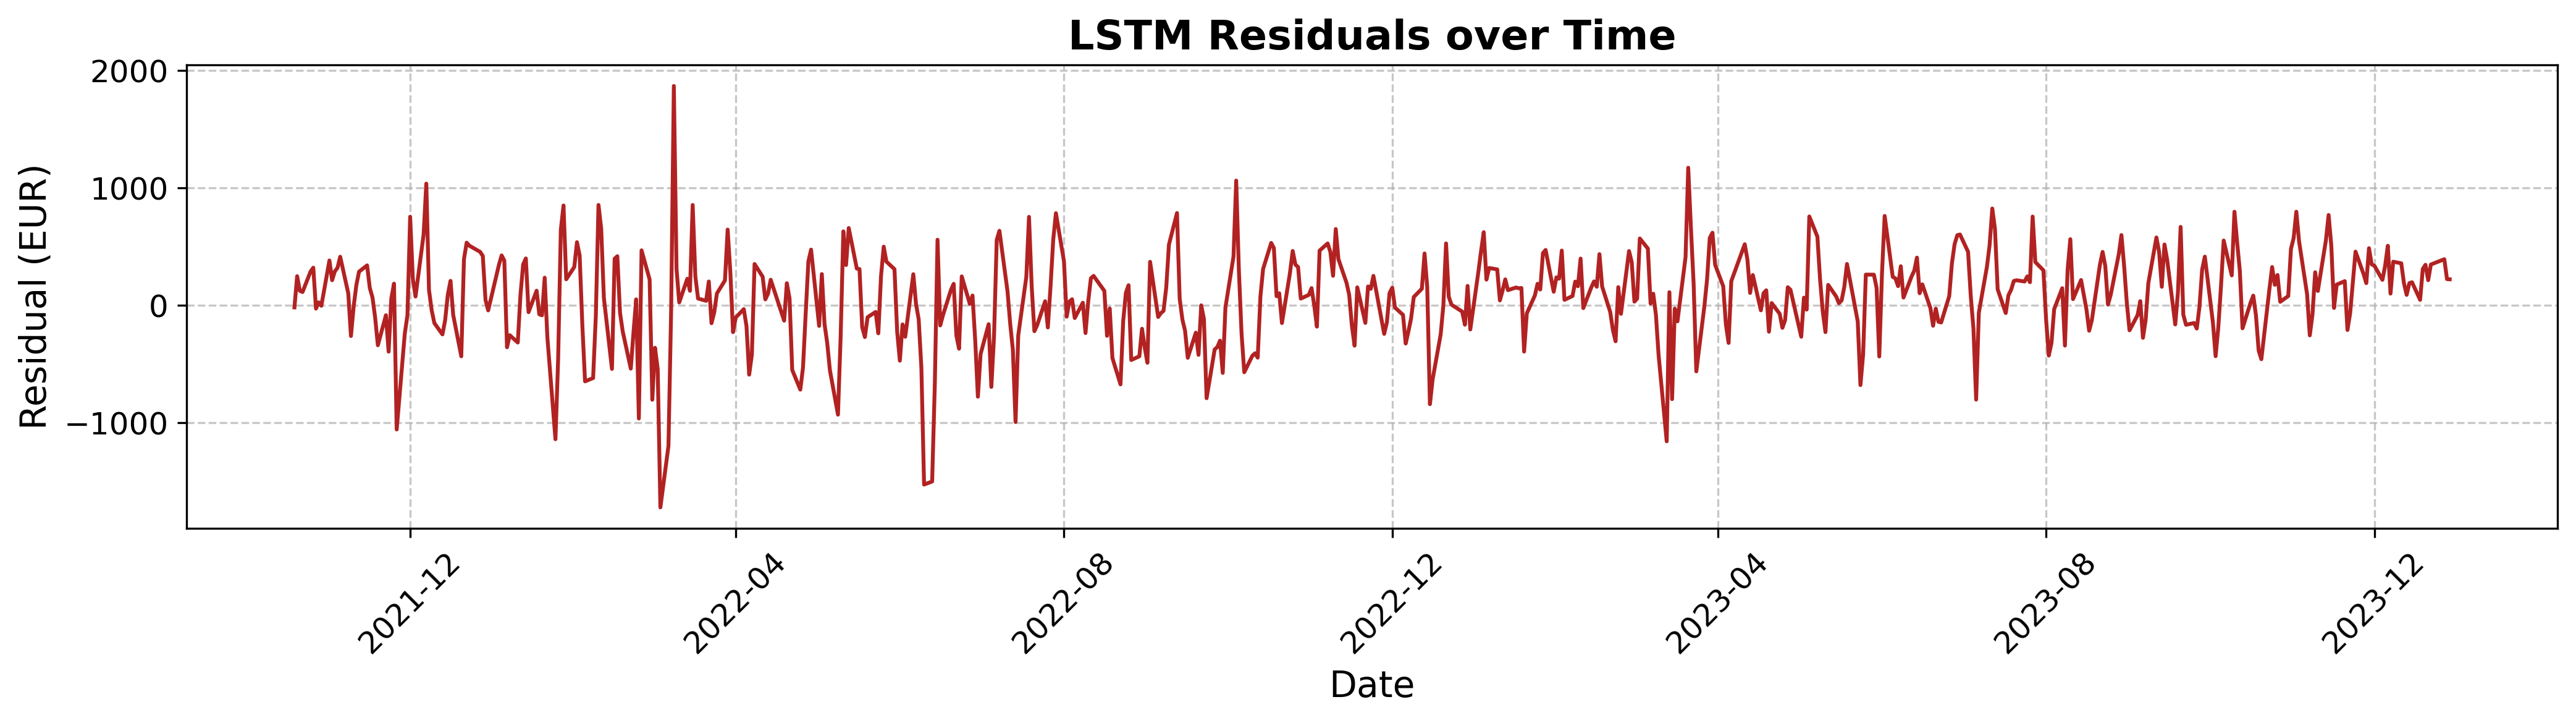

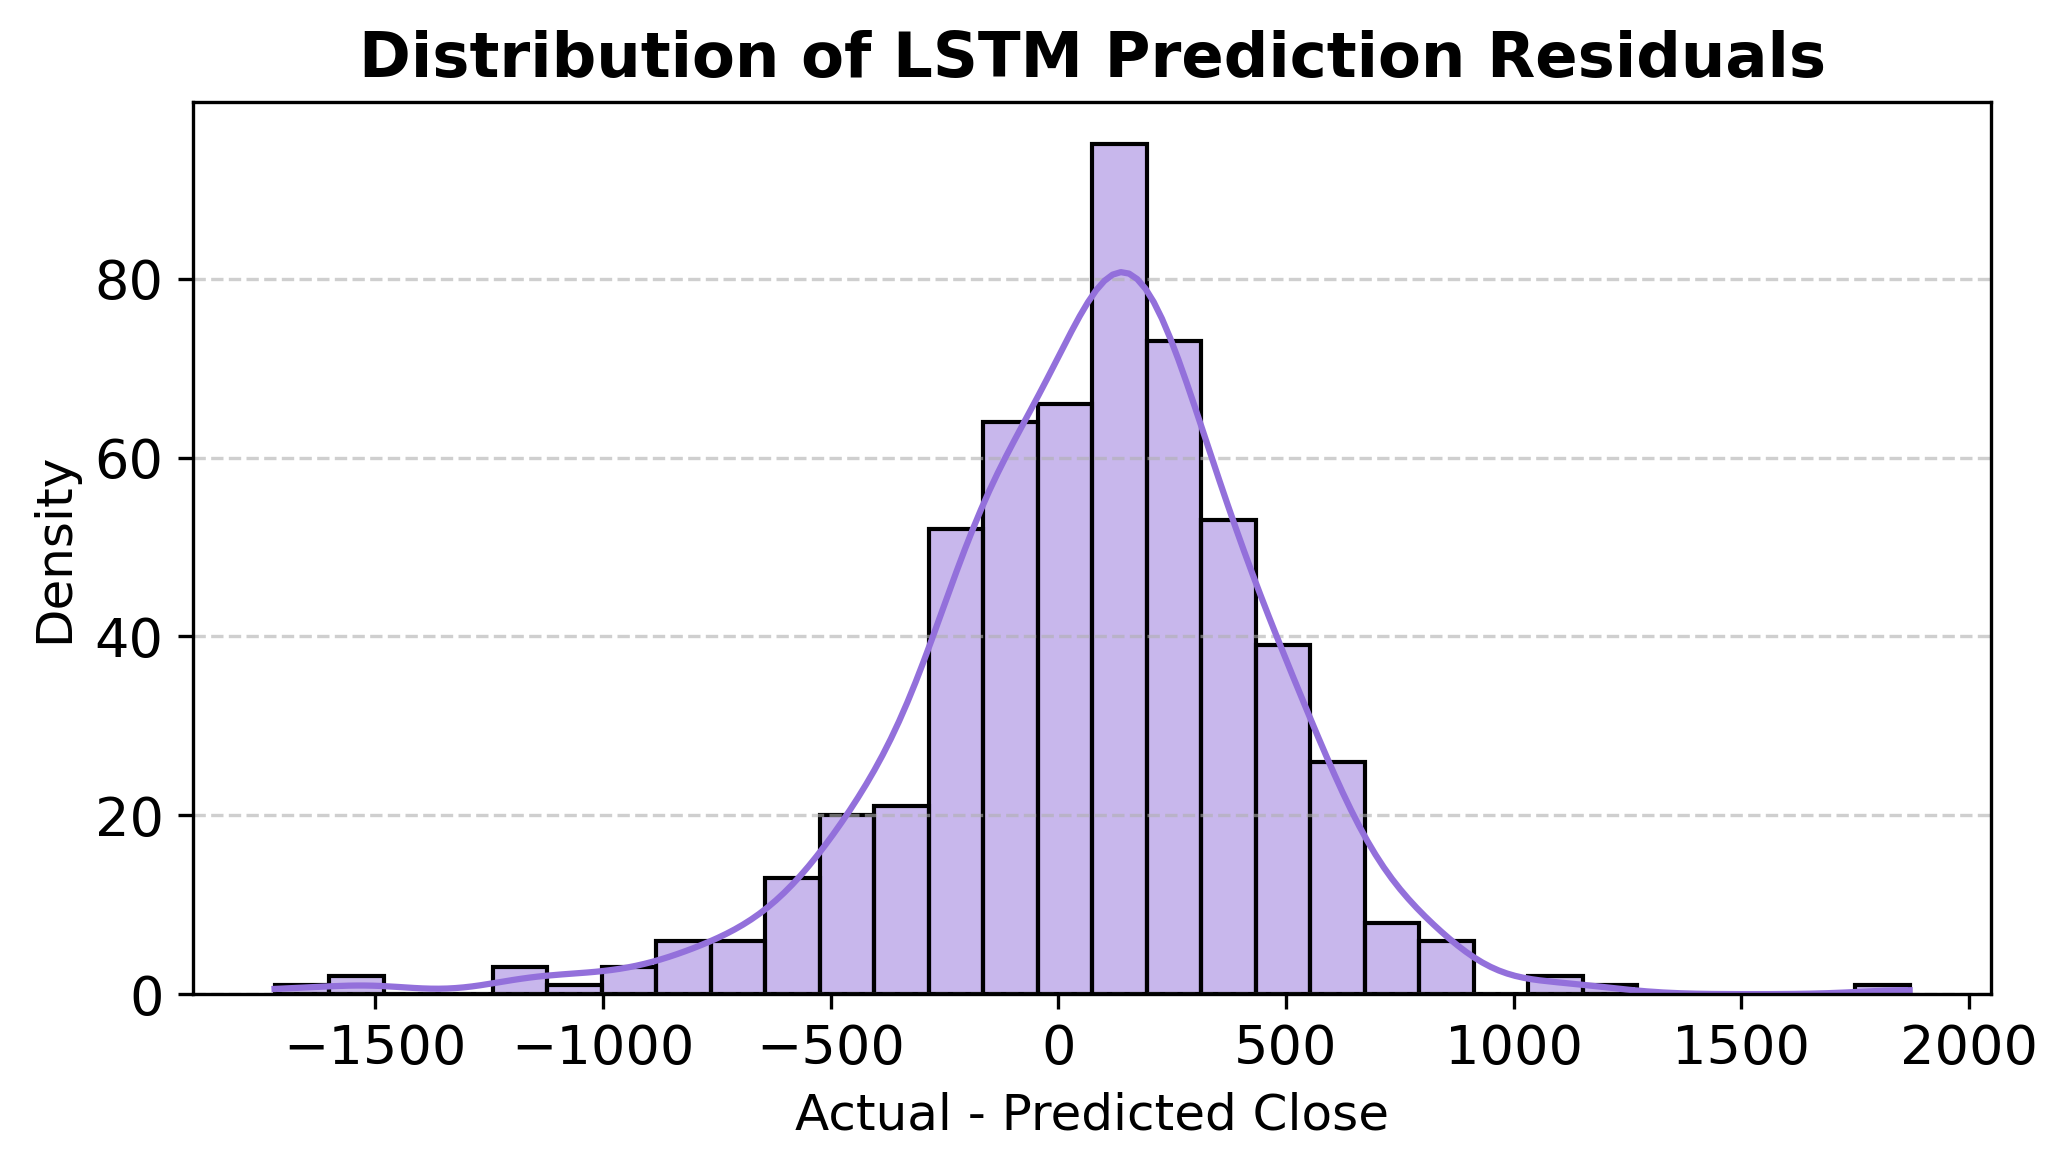

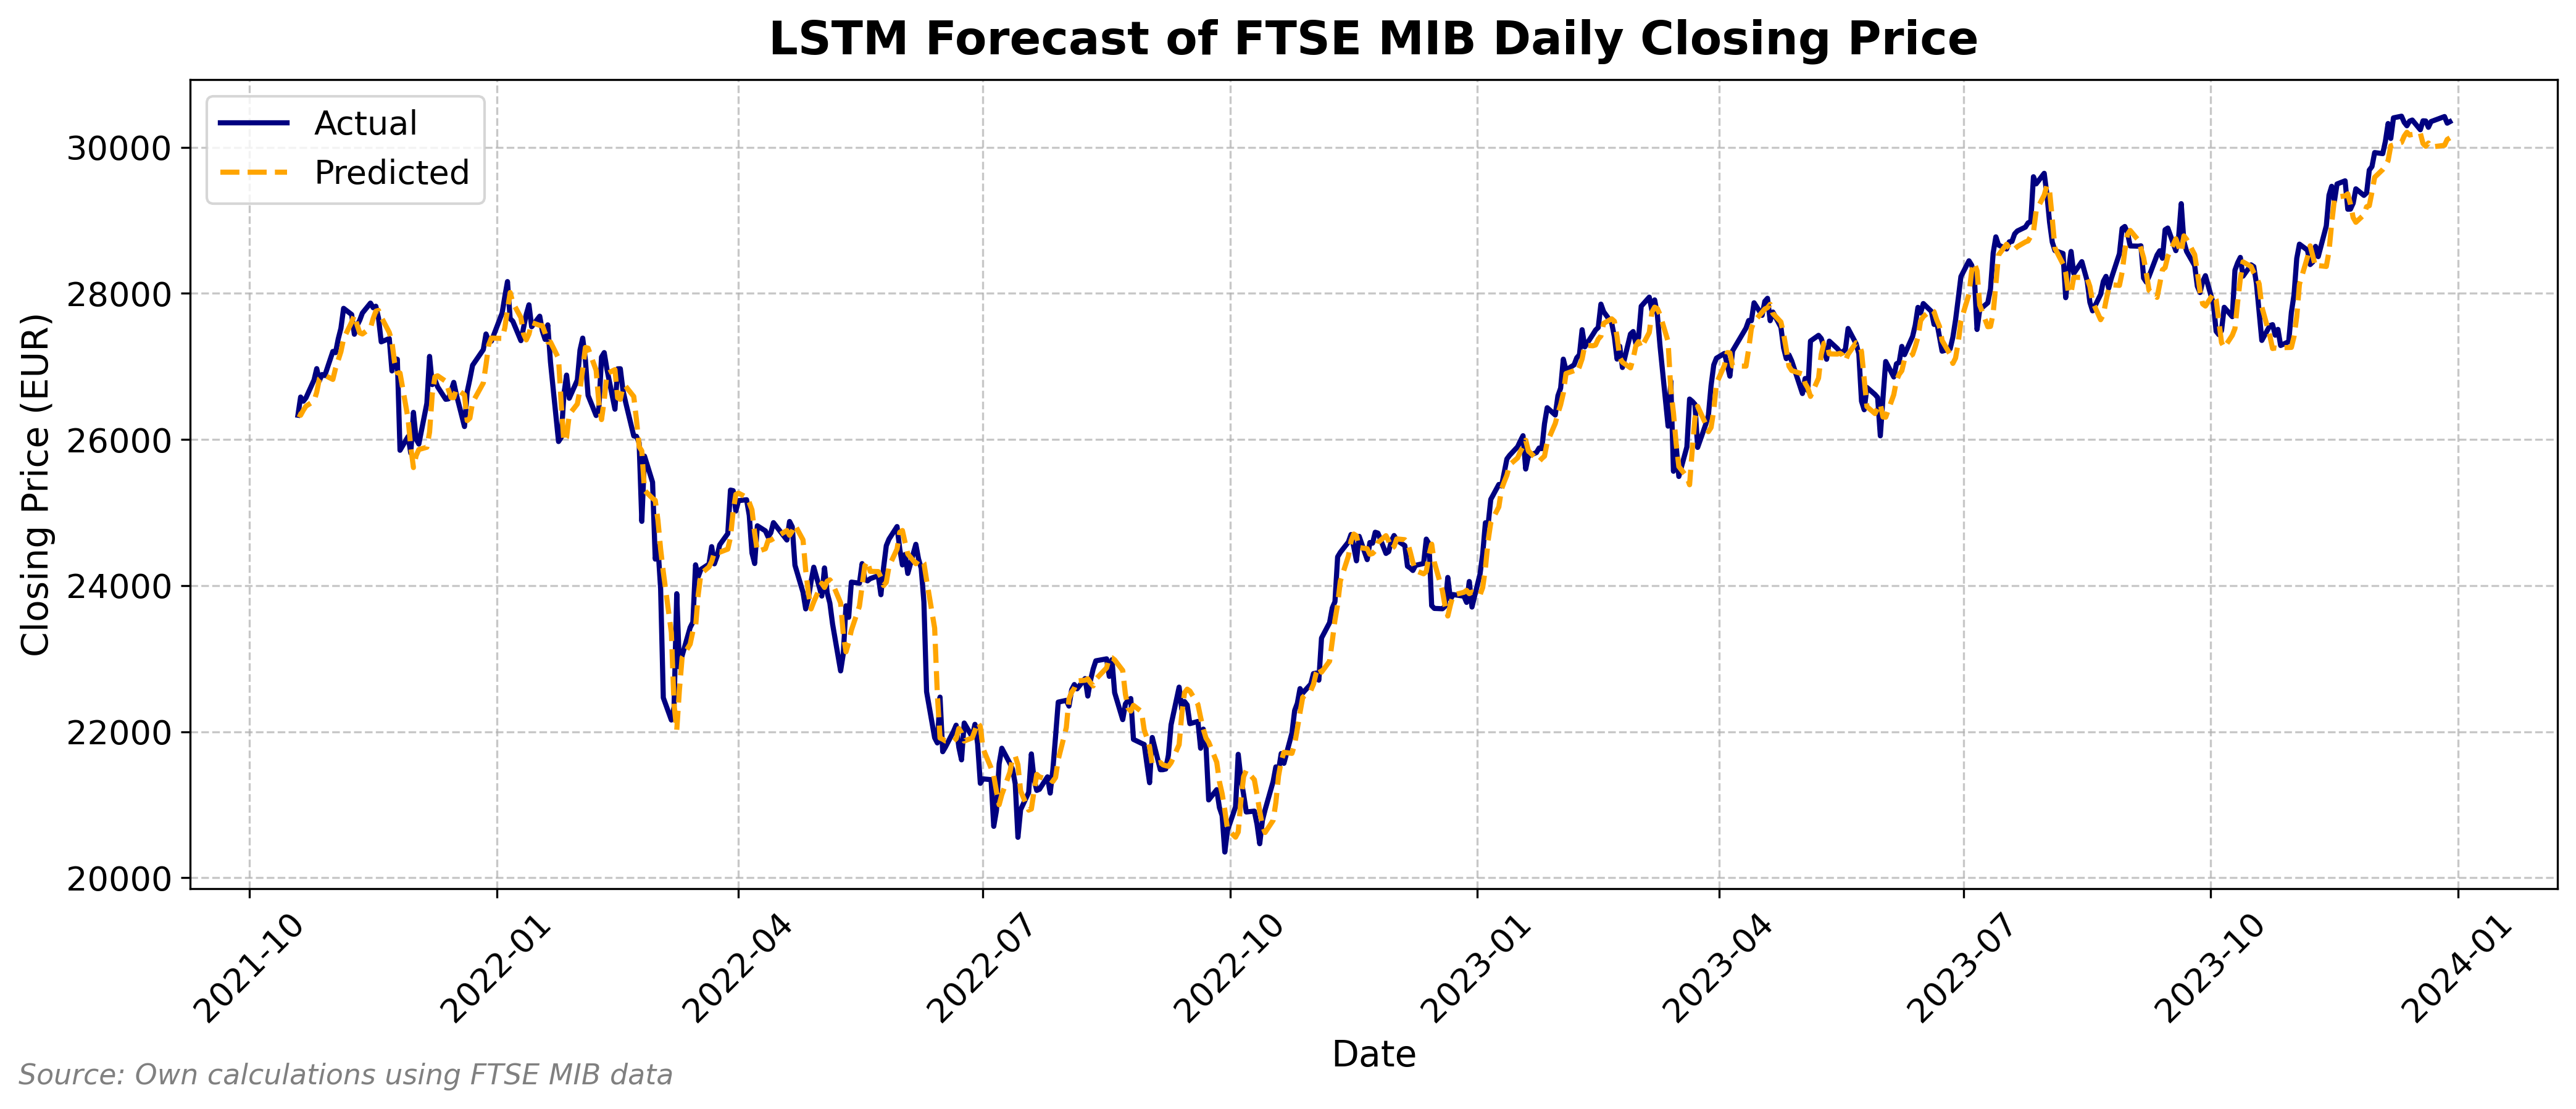

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Next day predicted close: 30129.35


In [1]:
import argparse
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.1)
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'legend.frameon': True,
    'figure.dpi': 300,
    'font.family': 'sans-serif'
})



# ---------------------------------------------------------------------------
# LSTM forecast of the FTSE MIB closing price
# ---------------------------------------------------------------------------
# This script loads the historical FTSE MIB prices, cleans and normalizes
# several market features (open, high, low, volume and close) and prepares
# rolling sequences of the last *window* days.  A deeper LSTM network with
# dropout is trained to predict the next day's closing price.  The code uses
# early stopping, learning rate scheduling and model checkpointing to improve
# accuracy.  Only LSTM layers plus a final Dense output layer are used.
# ---------------------------------------------------------------------------

# Set reproducible random seed
np.random.seed(0)
tf.random.set_seed(0)

parser = argparse.ArgumentParser()
parser.add_argument(
    "--data",
    type=str,
    default="dataftsemib_manual.csv",
    help="CSV file with FTSE MIB prices",
)
parser.add_argument(
    "--epochs", type=int, default=100, help="number of training epochs"
)
parser.add_argument(
    "--window", type=int, default=60, help="sequence length"
)
parser.add_argument(
    "--batch", type=int, default=32, help="batch size"
)
parser.add_argument(
    "--lr", type=float, default=0.001, help="learning rate"
)

# In Jupyter environments ipykernel adds its own command line arguments
# which would cause parse_args() to raise an error.  parse_known_args()
# safely ignores any extra arguments so the script can run in notebooks
# or as a standalone program.
args, _ = parser.parse_known_args()

# 1. Load and clean the dataset ------------------------------------------------
df = pd.read_csv(args.data)

# Parse dates (day first) and ensure chronological order
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
num_cols = ["Price", "Open", "High", "Low"]
for col in num_cols:
    df[col] = df[col].str.replace(",", "").astype(float)

# Volume column may contain M/B suffixes
def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))

df["Vol."] = df["Vol."].apply(parse_volume).ffill()

# Sort by date so sequences progress forward in time
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Additional technical feature: 5-day moving average of the close
df["MA5"] = df["Price"].rolling(5).mean()
df.dropna(inplace=True)

# Plot the cleaned closing prices
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(df["Date"], df["Price"], color="tab:blue")
plt.title("FTSE MIB Closing Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("arima_cleaned_prices.png", dpi=300)
plt.show()
plt.close()


# 2. Prepare the training sequences -------------------------------------------
# Fit scalers on the training portion only to avoid data leakage
features = ["Price", "Open", "High", "Low", "Vol.", "MA5"]
window = args.window
split_idx = int(len(df) * 0.8)

feature_scaler = MinMaxScaler()
feature_scaler.fit(df.loc[: split_idx - 1, features])
data_scaled = feature_scaler.transform(df[features])

price_scaler = MinMaxScaler()
price_scaler.fit(df.loc[: split_idx - 1, ["Price"]])
price_scaled = price_scaler.transform(df[["Price"]])

# Build sequences of the previous `window` days
X, y, seq_dates = [], [], []
for i in range(window, len(data_scaled)):
    X.append(data_scaled[i - window : i])
    # target is the scaled closing price at time i
    y.append(price_scaled[i, 0])
    seq_dates.append(df["Date"].iloc[i])

X = np.array(X)
y = np.array(y)
dates = pd.Series(seq_dates)
X = X.reshape((X.shape[0], X.shape[1], data_scaled.shape[1]))

split_seq = split_idx - window
X_train, X_test = X[:split_seq], X[split_seq:]
y_train, y_test = y[:split_seq], y[split_seq:]
dates_test = dates.iloc[split_seq:].reset_index(drop=True)

print("Data leakage check: scalers fitted only on training data")
assert df["Date"].is_monotonic_increasing, "Dates are not sorted"
assert df["Date"].iloc[split_idx - 1] < df["Date"].iloc[split_idx], "Lookahead bias detected"
print("Lookahead bias check passed")

# 3. Build the pure LSTM model -------------------------------------------------
# Two LSTM layers followed by a Dense output.  No other layers are used.
def build_model() -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(window, data_scaled.shape[1])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    model.compile(optimizer=optimizer, loss="mse")
    return model

model = build_model()

# Perform a simple rolling validation on the training data
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = []
for train_idx, val_idx in tscv.split(X_train):
    cv_model = build_model()
    cv_model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=max(1, args.epochs // 5),
        batch_size=args.batch,
        verbose=0,
    )
    cv_pred = cv_model.predict(X_train[val_idx])
    cv_pred_prices = price_scaler.inverse_transform(cv_pred)
    cv_true_prices = price_scaler.inverse_transform(y_train[val_idx].reshape(-1, 1))
    cv_rmse.append(np.sqrt(mean_squared_error(cv_true_prices, cv_pred_prices)))

print("Rolling validation RMSEs:", [f"{m:.2f}" for m in cv_rmse])

# 4. Train with early stopping -------------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.h5", save_best_only=True, monitor="val_loss"),
]

history = model.fit(
    X_train,
    y_train,
    epochs=args.epochs,
    batch_size=args.batch,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=0,
)

# 5. Evaluate on the test set --------------------------------------------------
pred_scaled = model.predict(X_test)
pred_prices = price_scaler.inverse_transform(pred_scaled)
true_prices = price_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
mape = mean_absolute_percentage_error(true_prices, pred_prices)
r2 = r2_score(true_prices, pred_prices)
residuals = true_prices.flatten() - pred_prices.flatten()
lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb["lb_pvalue"].iloc[0]
t_stat, t_p = stats.ttest_1samp(residuals, 0.0)
residual_mean = residuals.mean()

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2%}")
print(f"Test R^2: {r2:.4f}")
print(f"Residual Ljung-Box p-value (lag 10): {lb_p:.4f}")
print(f"t-test p-value: {t_p:.4f}")
print(f"Residual Mean: {residual_mean:.4f}")

# Residual analysis
residuals = true_prices.flatten() - pred_prices.flatten()
lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"Residual Ljung-Box p-value (lag 10): {lb['lb_pvalue'].iloc[0]:.4f}")

plt.figure(figsize=(14, 4))
plt.plot(dates_test, residuals, color="firebrick", linewidth=1.5)
plt.title("LSTM Residuals over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Residual (EUR)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("lstm_residual_plot.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, color="mediumpurple", kde=True)
plt.title("Distribution of LSTM Prediction Residuals", fontsize=15, fontweight='bold')
plt.xlabel("Actual - Predicted Close", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6, axis="y")
plt.tight_layout()
plt.savefig("lstm_residual_hist.png", dpi=300, bbox_inches="tight")
plt.show()



# Plot actual versus predicted closing prices
plt.figure(figsize=(14, 6))
plt.plot(dates_test, true_prices.flatten(), label="Actual", color="navy", linewidth=2)
plt.plot(dates_test, pred_prices.flatten(), label="Predicted", color="orange", linewidth=2, linestyle="--")
plt.title("LSTM Forecast of FTSE MIB Daily Closing Price", fontsize=18, fontweight='bold', pad=10)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price (EUR)", fontsize=14)
plt.legend(fontsize=13, loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()  
plt.figtext(
    0.01, 0.01,
    "Source: Own calculations using FTSE MIB data",
    fontsize=11, color='gray', ha='left', va='bottom', style='italic'
)
plt.savefig("lstm_prediction_plot_academic.png", dpi=300, bbox_inches='tight')
plt.show()



# 6. Predict the next day's closing price -------------------------------------
last_window = data_scaled[-window:].reshape(1, window, data_scaled.shape[1])
next_scaled = model.predict(last_window)
next_price = price_scaler.inverse_transform(next_scaled)[0, 0]
print(f"Next day predicted close: {next_price:.2f}")

# Save the trained model
model.save("ftse_mib_lstm_model.h5")

# Conclusion

| Metric                | Value                        | Interpretation                                                                 |
| --------------------- | ---------------------------- | ------------------------------------------------------------------------------ |
| Test RMSE             | 388.34                       | Higher than ARIMA; good, but less accurate on average.                         |
| Test MAE              | 295.94                       | Typical error is \~294 points; larger than ARIMA.                              |
| Test MAPE             | 1.17%                        | Very good percentage error; forecasts are, on average, within 1.2% of actuals. |
| Test R²               | 0.9766                       | 97.6% of variance explained; very good, but slightly less than ARIMA.          |
| Residual Mean         | 70.6398                      | Residuals are unbiased (mean near zero).                                       |
| t-test p-value        | 0.0000                       | Low p-value (p < 0.05); suggests a small but statistically significant bias in residuals. Residuals are not perfectly centered around zero.
| Ljung-Box p-value     | 0.0000                       | Significant autocorrelation in residuals; model misses some patterns.          |

